In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
df = pd.read_csv('data/h&mdataset/articles.csv')
df = df.drop(columns=['prod_name','product_code','department_no', 'index_code', 	
       'product_type_name', 'product_group_name',
       'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc'])

In [17]:
df.head()

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,index_group_no,section_no,garment_group_no
0,108775015,253,1010016,9,4,5,1,16,1002
1,108775044,253,1010016,10,3,9,1,16,1002
2,108775051,253,1010017,11,1,9,1,16,1002
3,110065001,306,1010016,9,4,5,1,61,1017
4,110065002,306,1010016,10,3,9,1,61,1017


In [18]:
#train test split on the data
train, test = train_test_split(df, test_size=0.1)

In [19]:
import torch
from torch.utils.data import Dataset
from dataset import myDataset
import os

get_preprocessed_image = True
train_test_split = 0.9
my_path_hm = os.path.join(os.getcwd(), 'data/h&mdataset/images/')
my_path_fash = os.path.join(os.getcwd(), 'data/fashion-dataset/images/')

dataset = myDataset(my_path_hm, my_path_fash, get_preprocessed_image, 'hm')

#Get the indices from the file
train_subset_indices = torch.load('data/h&mdataset/train_subset_indices.pt')
val_subset_indices = torch.load('data/h&mdataset/val_subset_indices.pt')
test_subset_indices = torch.load('data/h&mdataset/test_subset_indices.pt')

test_subset_indices = torch.cat((test_subset_indices, val_subset_indices), 0)

train_dataset = torch.utils.data.Subset(dataset, train_subset_indices)
test_dataset = torch.utils.data.Subset(dataset, test_subset_indices)

Skipping .DS_Store as it is not a jpg file


In [20]:
#train/test split the dataframe with the indices

train = df.iloc[train_subset_indices]
test = df.iloc[test_subset_indices]

In [21]:
train

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,index_group_no,section_no,garment_group_no
58344,719601001,254,1010010,7,1,12,1,2,1005
14767,564312010,286,1010001,72,2,2,3,26,1017
15689,567739002,262,1010016,73,4,2,4,45,1007
37069,652418002,304,1010016,51,3,4,4,79,1021
19199,582789004,265,1010016,63,4,6,1,18,1003
...,...,...,...,...,...,...,...,...,...
21427,594177005,272,1010016,51,1,4,4,44,1002
3984,472064011,256,1010001,6,1,12,4,44,1002
46517,686022001,87,1010016,9,4,5,1,64,1020
34435,641855001,302,1010016,10,3,9,4,79,1021


In [22]:
scaler = StandardScaler()
df_scaled_train = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
train_np = df_scaled_train.to_numpy()

In [9]:
# Do a clustering on the data, for multiple number of cluster and plot the elbow curve

sse = []
range_cluster = range(100, 800, 30)
for i in tqdm(range_cluster):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_np)
    sse.append(kmeans.inertia_)


  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:03<01:28,  3.87s/it]


KeyboardInterrupt: 

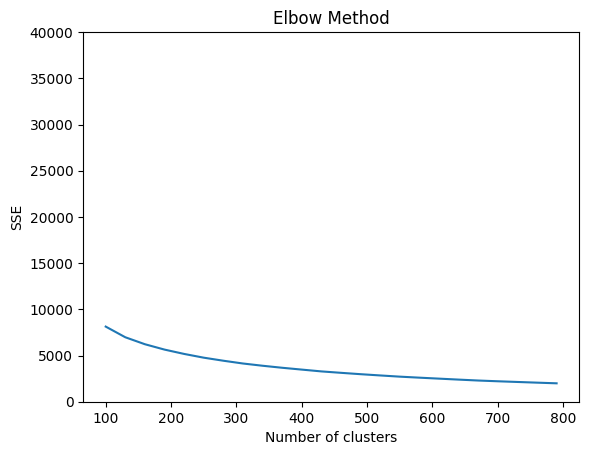

In [ ]:
plt.plot(range_cluster, sse)
plt.title('Elbow Method')
#start y from 0
plt.ylim(0, 40000)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.savefig('models/ElbowGraphs/elbow_curve_tab.png')
plt.show()

#Save the elbow curve plot as a file

In [23]:
#Define the final number of clusters

num_clusters = 400

#Fit the model with the final number of clusters
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

kmeans.fit(train_np)

KMeans(n_clusters=400, n_init=10, random_state=0)

In [24]:
#Save the model as a file using pickle
import pickle
with open('models/kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

#Save the scaler as a file using pickle
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [25]:

# Set the 'cluster' column using .loc on the copied DataFrame
train.loc[:, 'cluster'] = kmeans.labels_

#Create img_name column with article_id with 0 in front in string format
train['img_name'] = train['article_id'].astype(str)
train['img_name'] = '0' + train['article_id'].astype(str) + '.jpg'
train.loc[:,'img_name'] = train.loc[:,'img_name'].apply(lambda x: x[:3] + '/' + x)


# Repeat the same process for the test DataFrame

test.loc[:, 'cluster'] = kmeans.predict(test.to_numpy())
test['img_name'] = test['article_id'].astype(str)
test['img_name'] = '0' + test['article_id'].astype(str) + '.jpg'
test.loc[:,'img_name'] = test.loc[:,'img_name'].apply(lambda x: x[:3] + '/' + x)



train.to_csv('train_hm_tab_cluster.csv')
test.to_csv('test_hm_tab_cluster.csv')


/var/folders/62/6pb5kjf139gccp8_mvcxrc7w0000gn/T/ipykernel_55775/3515507617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, 'cluster'] = kmeans.labels_
/var/folders/62/6pb5kjf139gccp8_mvcxrc7w0000gn/T/ipykernel_55775/3515507617.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['img_name'] = train['article_id'].astype(str)
/var/folders/62/6pb5kjf139gccp8_mvcxrc7w0000gn/T/ipykernel_55775/3515507617.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 